<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/ColabNotebooks/FasterRCNN/Alexnet_FRCNN_vote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

In [2]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset, default_collate
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import utils

from WoodDataset import FasterRCNN_WoodDataset

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [4]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=1.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [5]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [6]:
train_data = FasterRCNN_WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = FasterRCNN_WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = FasterRCNN_WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [7]:
batch_size = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from Models import FasterRCNN_Backbone_Alexnet

modelname = 'Alexnet'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FasterRCNN_Backbone_Alexnet(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


In [9]:
checkpoint_epoch = 403
model.load_state_dict(torch.load(os.path.join('models', 'FasterRCNN', f'Alexnet_SGD_epoch_{checkpoint_epoch}_vote.pth')))

<All keys matched successfully>

In [11]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [12]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('FasterRCNN_logs_v2', f'FasterRCNN_{modelname}_{optimizer_type}_vote')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [13]:
def train_batch(model, images, targets):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  return loss_dict

In [ ]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_valid_loss = np.array([1000., 1000., 1000., 1000.])
last_update_epoch = 0
for epoch in range(checkpoint_epoch, num_epochs):

    train_box_loss = []
    train_cls_loss = []
    train_obj_loss = []
    train_rpn_loss = []
    valid_box_loss = []
    valid_cls_loss = []
    valid_obj_loss = []
    valid_rpn_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:
        torch.cuda.empty_cache()
        batch_size = len(images)
        n += 1

        loss_dict = train_batch(model, images, targets)
        '''
        loss__dict = {'loss_classifier': ###, 
                      'loss_box_reg': ###, 
                      'loss_objectness': ###, 
                      'loss_rpn_box_reg': ###}
        '''        
        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()

        train_box_loss.append(box_loss)
        train_cls_loss.append(cls_loss)
        train_obj_loss.append(obj_loss)
        train_rpn_loss.append(rpn_loss)

        losses = sum(loss_dict.values())     # Returns losses and detections

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        now = time.time()

        if n % 30 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] box_loss: {box_loss:.4f}  cls_loss: {cls_loss:.4f}  obj_loss: {obj_loss:.4f}  rpn_loss: {rpn_loss:.4f}')
          print(f'Training time: {tstr}')      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    images = None
    targets = None  
    loss_dict = None  
    torch.cuda.empty_cache()
############################# valid #########################################           
    with  torch.no_grad():
      for images, targets in valid_data_loader:

          torch.cuda.empty_cache()
          loss_dict = train_batch(model, images, targets)

          cls_loss = loss_dict['loss_classifier'].item()
          box_loss = loss_dict['loss_box_reg'].item()
          obj_loss = loss_dict['loss_objectness'].item()
          rpn_loss = loss_dict['loss_rpn_box_reg'].item()
          losses = sum(loss_dict.values())

          valid_box_loss.append(box_loss)
          valid_cls_loss.append(cls_loss)
          valid_obj_loss.append(obj_loss)
          valid_rpn_loss.append(rpn_loss)
          # val_loss_hist.send(val_loss_value)
    images = None
    targets = None 
    loss_dict = None
    torch.cuda.empty_cache()

############################ log ###########################################
    epoch_train_box_loss = np.mean(train_box_loss)
    epoch_train_cls_loss = np.mean(train_cls_loss)
    epoch_train_obj_loss = np.mean(train_obj_loss)
    epoch_train_rpn_loss = np.mean(train_rpn_loss)
    epoch_valid_box_loss = np.mean(valid_box_loss)
    epoch_valid_cls_loss = np.mean(valid_cls_loss)
    epoch_valid_obj_loss = np.mean(valid_obj_loss)
    epoch_valid_rpn_loss = np.mean(valid_rpn_loss)

    current_valid_loss = np.array([epoch_valid_box_loss, 
                              epoch_valid_cls_loss, 
                              epoch_valid_obj_loss, 
                              epoch_valid_rpn_loss])

    now = time.time()
    writer.add_scalar('train/box_loss', epoch_train_box_loss, epoch, now)
    writer.add_scalar('train/cls_loss', epoch_train_cls_loss, epoch, now)
    writer.add_scalar('train/obj_loss', epoch_train_obj_loss, epoch, now)
    writer.add_scalar('train/rpn_loss', epoch_train_rpn_loss, epoch, now)
    writer.add_scalar('valid/box_loss', epoch_valid_box_loss, epoch, now)
    writer.add_scalar('valid/cls_loss', epoch_valid_cls_loss, epoch, now)
    writer.add_scalar('valid/obj_loss', epoch_valid_obj_loss, epoch, now)
    writer.add_scalar('valid/rpn_loss', epoch_valid_rpn_loss, epoch, now)

############################ save ##########################################   
    if sum(current_valid_loss < best_valid_loss) >= 3:
        best_valid_loss = current_valid_loss
        print(f'Model Updated! Validation box_loss: {best_valid_loss[0]:.4f}  cls_loss: {best_valid_loss[1]:.4f}  obj_loss: {best_valid_loss[2]:.4f}  rpn_loss: {best_valid_loss[3]:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}_vote.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}_vote.pth'
        torch.save(model.state_dict(), os.path.join('models', 'FasterRCNN', save_name))

        if os.path.exists(os.path.join('models', 'FasterRCNN', last_save_name)):
          os.remove(os.path.join('models', 'FasterRCNN', last_save_name))
        last_update_epoch = epoch
#############################################################################
writer.close()

Epoch: [275] [30/361] box_loss: 0.0527  cls_loss: 0.0432  obj_loss: 0.0105  rpn_loss: 0.0084
Training time: 00:03:12
Epoch: [275] [60/361] box_loss: 0.0497  cls_loss: 0.0407  obj_loss: 0.0068  rpn_loss: 0.0026
Training time: 00:06:09
Epoch: [275] [90/361] box_loss: 0.0508  cls_loss: 0.0533  obj_loss: 0.0246  rpn_loss: 0.0077
Training time: 00:09:09
Epoch: [275] [120/361] box_loss: 0.0699  cls_loss: 0.0718  obj_loss: 0.0155  rpn_loss: 0.0092
Training time: 00:12:05
Epoch: [275] [150/361] box_loss: 0.0445  cls_loss: 0.0435  obj_loss: 0.0179  rpn_loss: 0.0121
Training time: 00:15:02
Epoch: [275] [180/361] box_loss: 0.0736  cls_loss: 0.0479  obj_loss: 0.0128  rpn_loss: 0.0155
Training time: 00:17:54
Epoch: [275] [210/361] box_loss: 0.0702  cls_loss: 0.0643  obj_loss: 0.0374  rpn_loss: 0.0246
Training time: 00:20:50
Epoch: [275] [240/361] box_loss: 0.0570  cls_loss: 0.0517  obj_loss: 0.0210  rpn_loss: 0.0301
Training time: 00:23:43
Epoch: [275] [270/361] box_loss: 0.0691  cls_loss: 0.0807  

In [ ]:
loss_dict

{'loss_classifier': tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0483, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0295, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}

In [10]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [12]:
idx = 0
# model.load_state_dict(torch.load(os.path.join('models','Alexnet_SGD_epoch_102.pth')))
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

{'boxes': tensor([[506.4510, 376.9954, 543.2925, 409.7996],
         [ 58.6003, 348.4361, 113.1744, 383.2658],
         [514.6911, 380.1769, 536.6060, 404.0041],
         [863.4963, 269.5097, 906.5040, 299.1108],
         [868.7119, 270.5491, 897.9150, 296.1730],
         [ 70.2798, 350.8441, 125.1868, 387.9691],
         [506.6264, 381.1398, 525.3578, 408.5818],
         [865.3109, 270.6120, 893.1904, 288.3913],
         [449.9857, 493.3721, 482.6081, 510.9451],
         [426.9149, 493.0466, 457.3790, 508.7636],
         [449.8999, 493.3575, 482.8704, 510.9908],
         [426.8348, 493.0335, 457.6240, 508.8045],
         [857.6736, 261.2280, 925.2820, 307.6962],
         [449.9135, 493.3161, 482.8137, 510.9926],
         [426.8475, 492.9965, 457.5711, 508.8061],
         [ 62.3920, 350.6675, 114.0646, 381.6181],
         [449.9540, 493.3118, 482.7341, 511.0010],
         [426.8853, 492.9926, 457.4968, 508.8136],
         [449.7953, 493.4169, 482.7183, 511.0361],
         [426.7371, 49

In [13]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [14]:
bbox_pred

tensor([[506.4510, 376.9954, 543.2925, 409.7996],
        [ 58.6003, 348.4361, 113.1744, 383.2658],
        [863.4963, 269.5097, 906.5040, 299.1108],
        [449.9857, 493.3721, 482.6081, 510.9451],
        [662.6677,   2.6723, 702.7631, 281.5160]], grad_fn=<ToCopyBackward0>)

In [15]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 2, 2])

Text(0.5, 1.0, 'Gt')

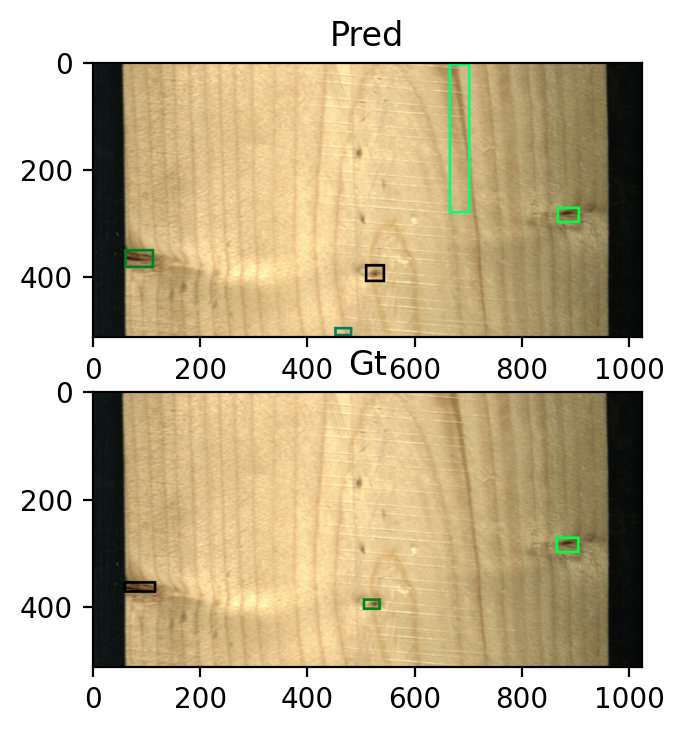

In [16]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [17]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.5).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(0.4000)

In [18]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

with torch.inference_mode():
  for idx in range(len(test_data)):
    image = test_data[idx][0]
    target = test_data[idx][1]
    rec = model(image.unsqueeze(0).to(device))
    rec = rec[0]

    nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
    bbox_pred = rec['boxes'][nms_idx].cpu()
    labels_pred = rec['labels'][nms_idx].cpu()

    bbox_gt = target['boxes']
    labels_gt = target['labels']

    cm = box_iou(bbox_gt, bbox_pred)
    box_TP = (cm>0.5).sum()
    box_FP = len(bbox_pred) - box_TP
    box_FN = len(bbox_gt) - box_TP

    box_precision = box_TP/(box_TP + box_FP + eps)
    box_recall = box_TP/(box_TP + box_FN + eps)

    box_precisions.append(box_precision)
    box_recalls.append(box_recall)

    gt2 = labels_gt[cm.argmax(dim=0)]
    for i in range(len(gt2)):
      cls_cm[gt2[i]-1, labels_pred[i]-1] += 1
    if (idx+1)%30 ==0 :
      print(f'Done {idx+1}/{len(test_data)}')

Done 30/361
Done 60/361
Done 90/361
Done 120/361
Done 150/361
Done 180/361
Done 210/361
Done 240/361
Done 270/361
Done 300/361
Done 330/361
Done 360/361


In [21]:
with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN_vote.npy'), 'wb') as f:
  np.save(f, cls_cm)

In [22]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
print(f'class precision: {cls_precision.mean():.4f}, class recall: {cls_recall.mean():.4f}')

class precision: 0.4943, class recall: 0.4359


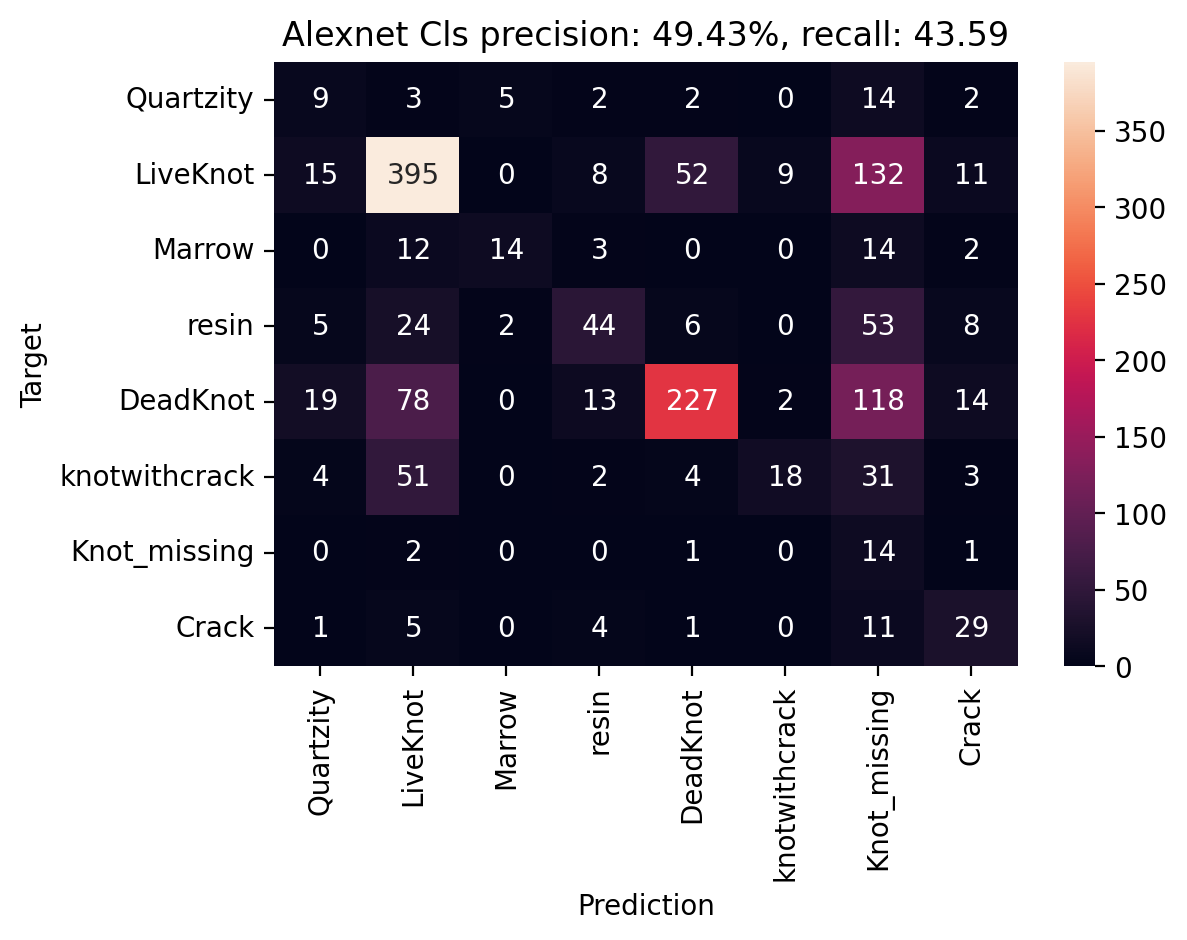

In [23]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN_vote.png'))
           

In [24]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

,box_precision,box_recall
0,0.400000,0.666666
1,0.250000,0.500000
2,0.666666,0.666666
3,0.500000,0.999999
4,0.500000,1.000000
5,0.666667,1.000000
6,0.500000,1.000000
7,0.333333,0.999999
8,0.500000,0.500000
9,0.999999,0.999999


In [25]:
print(df['box_precision'].mean())
print(df['box_recall'].mean())

0.5098444131148819
0.8010691411359818


In [ ]:
df.to_csv(os.path.join('Validation_csv', save_name.replace('pth', 'csv')))